# Outlook

In this notebook, using BBRL, we code the DDPG algorithm.

To understand this code, you need to know more about [the BBRL interaction
model](https://github.com/osigaud/bbrl/blob/master/docs/overview.md) Then you
should run [a didactical
example](https://github.com/osigaud/bbrl/blob/master/docs/notebooks/03-multi_env_autoreset.student.ipynb)
to see how agents interact in BBRL when autoreset=True.

The DDPG algorithm is explained in [this
video](https://www.youtube.com/watch?v=0D6a0a1HTtc) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/ddpg.pdf).

## 展望

在这个笔记本中，我们将使用 BBRL 编写 DDPG（Deep Deterministic Policy Gradient）算法。

为了理解这些代码，你需要了解更多关于 [BBRL 交互模型](https://github.com/osigaud/bbrl/blob/master/docs/overview.md) 的信息。然后，你应该运行 [一个教学示例](https://github.com/osigaud/bbrl/blob/master/docs/notebooks/03-multi_env_autoreset.student.ipynb)，以查看当 `autoreset=True` 时，代理如何在 BBRL 中进行交互。

DDPG 算法的解释可以参考 [这个视频](https://www.youtube.com/watch?v=0D6a0a1HTtc)，你还可以阅读 [相关幻灯片](http://pages.isir.upmc.fr/~sigaud/teach/ddpg.pdf)。

In [1]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
import copy
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter


/home/chen_guanyu/deepdac/lib/python3.10/site-packages/bbrl_utils/notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401
error: XDG_RUNTIME_DIR not set in the environment.
2024-10-16 16:10:38.569376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 16:10:38.605568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 16:10:38.616709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 16:10:38.711619: I tenso

# Learning environment

## Configuration

The learning environment is controlled by a configuration providing a few
important things as described in the example below. This configuration can
hold as many extra information as you need, the example below is the minimal
one.

## 学习环境

### 配置

学习环境由配置控制，配置提供了一些重要信息，如下例所示。这个配置可以包含你需要的任意额外信息，下面的例子是最基本的配置。

```python
params = {
    # This defines the a path for logs and saved models
    "base_dir": "${gym_env.env_name}/myalgo_${current_time:}",

    # The Gymnasium environment
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },

    # Algorithm
    "algorithm": {
        # Seed used for the random number generator
        "seed": 1023,

        # Number of parallel training environments
        "n_envs": 8,

        # Number of transitions to collect at each epoch for an environment.
        # This number has to be multiplied by n_envs to get the number of new transitions
        # collected at each epoch.
        "n_steps": 100,

        # Number of transitions before starting to train
        "learning_starts": 10_000,
                
        # Minimum number of steps between two evaluations
        "eval_interval": 500,
        
        # Number of parallel evaluation environments
        "nb_evals": 10,

        # Number of epochs (loops)
        "max_epochs": 40000,
    },
}

# Creates the configuration object, i.e. cfg.algorithm.nb_evals is 10
cfg = OmegaConf.create(params)
```

## The RL algorithm

In this notebook, the RL algorithm is based on `EpochBasedAlgo`, that defines
the algorithm environment when using episodes. To use such environment, we
just need to subclass `EpochBasedAlgo` and to define two things, namely the
`train_policy` and the `eval_policy`. Both are BBRL agents that, given the
environment state, select the action to perform.

## 强化学习算法

在这个笔记本中，强化学习算法基于 `EpochBasedAlgo`，它定义了在使用回合（episodes）时的算法环境。为了使用这种环境，我们只需要继承 `EpochBasedAlgo` 类，并定义两个内容，即 `train_policy` 和 `eval_policy`。这两个都是 BBRL Agent，给定环境状态后，选择要执行的动作。

```py
  class MyAlgo(EpochBasedAlgo):
      def __init__(self, cfg):
          super().__init__(cfg)

          # Define the train and evaluation policies
          # (the agents compute the workspace `action` variable)
          self.train_policy = MyPolicyAgent(...)
          self.eval_policy = MyEvalAgent(...)

algo = MyAlgo(cfg)
```

The `EpochBasedAlgo` defines useful objects:

- `algo.cfg` is the configuration
- `algo.nb_steps` (integer) is the number of steps since the training began
- `algo.logger` is a logger that can be used to collect statistics during training:
    - `algo.logger.add_log("critic_loss", critic_loss, algo.nb_steps)` registers the `critic_loss` value on tensorboard
- `algo.evaluate()` evaluates the current `eval_policy` if needed, and keeps the
agent if it was the best so far (average cumulated reward);
- `algo.visualize_best()` runs the best agent on one episode, and displays the video

`EpochBasedAlgo` 定义了一些有用的对象：

- `algo.cfg` 是配置对象
- `algo.nb_steps`（整数）表示从训练开始以来的步骤数
- `algo.logger` 是一个日志记录器，用于在训练期间收集统计信息：
  - `algo.logger.add_log("critic_loss", critic_loss, algo.nb_steps)` 将 `critic_loss` 值记录到 TensorBoard 上
- `algo.evaluate()` 评估当前的 `eval_policy`（如果需要），并保留它作为最好的代理（根据平均累计奖励）；
- `algo.visualize_best()` 运行最佳代理在一个回合中，并显示视频

The [DDPG](https://arxiv.org/pdf/1509.02971.pdf) algorithm is an actor critic
algorithm. We use a simple neural network builder function. This neural
networks plays the role of the actor and the critic.

[DDPG](https://arxiv.org/pdf/1509.02971.pdf) 算法是一种 actor-critic 算法。在这里，我们使用一个简单的神经网络构建函数，这个神经网络同时担任 actor 和 critic 的角色。

## Definition of agents

The critic is a neural network taking the state $s$ and action $a$ as input,
and its output layer has a unique neuron whose value is the value of being in
that state and performing that action $Q(s,a)$.

As usual, the ```forward(...)``` function is used to write Q-values in the
workspace from time indexes, whereas the ```predict_value(...)``` function` is
used in other contexts, such as plotting a view of the Q function.

## 定义智能体

**Critic** 是一个神经网络，它以状态 $s$ 和动作 $a$ 作为输入，其输出层有一个神经元，该神经元的值表示在状态 $s$ 下采取动作 $a$ 的价值 $Q(s,a)$。

如同常规操作，`forward(...)` 函数用于从时间索引中写入 Q 值到工作空间，而 `predict_value(...)` 函数则用于其他场景，比如绘制 Q 函数的视图。

In [2]:
class ContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.model = build_mlp(
            [state_dim + action_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t):
        # Get the current state $s_t$ and the chosen action $a_t$
        obs = self.get(("env/env_obs", t))  # shape B x D_{obs}
        action = self.get(("action", t))  # shape B x D_{action}

        # Compute the Q-value(s_t, a_t)
        obs_act = torch.cat((obs, action), dim=1)  # shape B x (D_{obs} + D_{action})
        # Get the q-value (and remove the last dimension since it is a scalar)
        q_value = self.model(obs_act).squeeze(-1)
        self.set((f"{self.prefix}q_value", t), q_value)

    def predict_value(self, obs, action):
        obs_act = torch.cat((obs, action), dim=0)
        q_value = self.model(obs_act)
        return q_value

The actor is also a neural network, it takes a state $s$ as input and outputs
an action $a$.

actor 也是一个神经网络，它以状态 $s$ 作为输入，并输出一个动作 $a$。

In [3]:
class ContinuousDeterministicActor(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(
            layers, activation=nn.ReLU(), output_activation=nn.Tanh()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        action = self.model(obs)
        self.set(("action", t), action)

    def predict_action(self, obs, stochastic):
        assert (
            not stochastic
        ), "ContinuousDeterministicActor cannot provide stochastic predictions"
        return self.model(obs)

### Creating an Exploration method

In the continuous action domain, basic exploration differs from the methods
used in the discrete action domain. Here we generally add some Gaussian noise
to the output of the actor.

### 创建探索方法

在连续动作领域，基本的探索方法与离散动作领域使用的方法有所不同。在这里，我们通常会在 actor 的输出上添加一些高斯噪声。

In [4]:
from torch.distributions import Normal

In [5]:
class AddGaussianNoise(Agent):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        dist = Normal(act, self.sigma)
        action = dist.sample()
        self.set(("action", t), action)

In [the original DDPG paper](https://arxiv.org/pdf/1509.02971.pdf), the
authors rather used the more sophisticated Ornstein-Uhlenbeck noise where
noise is correlated between one step and the next.

在 [原始 DDPG 论文](https://arxiv.org/pdf/1509.02971.pdf) 中，作者使用了更复杂的 Ornstein-Uhlenbeck 噪声，这种噪声在连续的步骤之间具有相关性。

In [6]:
class AddOUNoise(Agent):
    """
    Ornstein Uhlenbeck process noise for actions as suggested by DDPG paper
    """

    def __init__(self, std_dev, theta=0.15, dt=1e-2):
        self.theta = theta
        self.std_dev = std_dev
        self.dt = dt
        self.x_prev = 0

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        x = (
            self.x_prev
            + self.theta * (act - self.x_prev) * self.dt
            + self.std_dev * math.sqrt(self.dt) * torch.randn(act.shape)
        )
        self.x_prev = x
        self.set(("action", t), x)

### Compute critic loss

Detailed explanations of the function to compute the critic loss
are given in [the DQN notebook](http://master-dac.isir.upmc.fr/rld/rl/03-1-dqn-introduction.student.ipynb)

### 计算 Critic 损失

计算 Critic 损失的详细解释可以参考 [DQN 笔记本](http://master-dac.isir.upmc.fr/rld/rl/03-1-dqn-introduction.student.ipynb)。

In [7]:
# Defines the (Torch) mse loss function
# `mse(x, y)` computes $\|x-y\|^2$
mse = nn.MSELoss()


def compute_critic_loss(cfg, reward, must_bootstrap, q_values, target_q_values):
    """Compute the DDPG critic loss from a sample of transitions

    :param cfg: The configuration
    :param reward: The reward (shape 2xB)
    :param must_bootstrap: Must bootstrap flag (shape 2xB)
    :param q_values: The computed Q-values (shape 2xB)
    :param target_q_values: The Q-values computed by the target critic (shape 2xB)
    :return: the loss (a scalar)
    """
    # Compute temporal difference
    target = (
        reward[1]
        + cfg.algorithm.discount_factor * target_q_values[1] * must_bootstrap[1].int()
    )
    # Compute critic loss
    critic_loss = mse(q_values[0], target)
    return critic_loss

### Compute actor loss
The actor loss is straightforward. We want the actor to maximize Q-values, thus we minimize the mean of negated Q-values.

### 计算 Actor 损失

Actor 的损失函数比较直接。我们希望 Actor 最大化 Q 值，因此我们最小化 Q 值负值的平均值。

In [8]:
def compute_actor_loss(q_values):
    """Returns the actor loss

    :param q_values: The q-values (shape 2xB)
    :return: A scalar (the loss)
    """
    return -q_values[0].mean()

### Create the DDPG agent

In the next cell, we create the critic and the actor, but also an exploration
agent to add noise and a target critic. The version below does not use a
target actor as it proved hard to tune, but such a target actor is used in the
original paper.

### 创建 DDPG 智能体

在接下来的代码单元中，我们将创建 Critic 和 Actor，还将创建一个用于添加噪声的探索智能体和一个目标 Critic。以下版本不使用目标 Actor，因为调优目标 Actor 较为困难，但在原始论文中确实使用了目标 Actor。

In [9]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

## Main training loop

In the following, we code the main loop

## 主要训练循环

在接下来的代码中，我们将实现 DDPG 算法的主要训练循环。

In [10]:
def run_ddpg(ddpg: DDPG):
    for rb in ddpg.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(ddpg.cfg.algorithm.batch_size)
        terminated, reward = rb_workspace["env/terminated", "env/reward"]

        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://github.com/osigaud/bbrl/blob/master/docs/time_limits.md
        must_bootstrap = ~terminated

        # Critic update
        # compute q_values: at t, we have Q(s,a) from the (s,a) in the RB
        ddpg.t_critic(rb_workspace, t=0, n_steps=1)

        with torch.no_grad():
            # replace the action at t+1 in the RB with \pi(s_{t+1}), to compute
            # Q(s_{t+1}, \pi(s_{t+1}) below
            ddpg.t_actor(rb_workspace, t=1, n_steps=1)
            # compute q_values: at t+1 we have Q(s_{t+1}, \pi(s_{t+1})
            ddpg.t_target_critic(rb_workspace, t=1, n_steps=1)

        # finally q_values contains the above collection at t=0 and t=1
        q_values, post_q_values = rb_workspace[
            "critic/q_value", "target-critic/q_value"
        ]

        # Compute critic loss
        critic_loss = compute_critic_loss(
            ddpg.cfg, reward, must_bootstrap, q_values, post_q_values
        )
        ddpg.logger.add_log("critic_loss", critic_loss, ddpg.nb_steps)
        ddpg.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.critic.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.critic_optimizer.step()

        # Actor update

        # Now we determine the actions the current policy would take in the states from the RB
        ddpg.t_actor(rb_workspace, t=0, n_steps=1)

        # We determine the Q values resulting from actions of the current policy
        ddpg.t_critic(rb_workspace, t=0, n_steps=1)

        # and we back-propagate the corresponding loss to maximize the Q values
        q_values = rb_workspace["critic/q_value"]
        actor_loss = compute_actor_loss(q_values)

        ddpg.logger.add_log("actor_loss", actor_loss, ddpg.nb_steps)

        # if -25 < actor_loss < 0 and nb_steps > 2e5:
        ddpg.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.actor.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.actor_optimizer.step()

        # Soft update of target q function
        soft_update_params(
            ddpg.critic, ddpg.target_critic, ddpg.cfg.algorithm.tau_target
        )

        if ddpg.evaluate():
            if ddpg.cfg.plot_agents:
                plot_policy(
                    ddpg.actor,
                    ddpg.eval_env,
                    ddpg.best_reward,
                    str(ddpg.base_dir / "plots"),
                    ddpg.cfg.gym_env.env_name,
                    stochastic=False,
                )

# Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

# 参数定义

日志记录器定义为 `bbrl.utils.logger.TFLogger`，以便使用 TensorBoard 进行可视化。

In [11]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.98,
        "buffer_size": 2e5,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 11_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "Pendulum-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

## Launching tensorboard to visualize the results

## 启动 tensorboard 以可视化结果

In [12]:
setup_tensorboard("./outputs/tblogs")

Reusing TensorBoard on port 6006 (pid 752), started 6 days, 23:17:45 ago. (Use '!kill 752' to kill it.)

In [14]:
ddpg = DDPG(OmegaConf.create(params))
run_ddpg(ddpg)
ddpg.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in outputs/Pendulum-v1/ddpg-S1_20241007-181158/best_agent.mp4
Moviepy - Building video /home/chen_guanyu/M2A/M2A_RLD/outputs/Pendulum-v1/ddpg-S1_20241007-181158/best_agent.mp4.
Moviepy - Writing video /home/chen_guanyu/M2A/M2A_RLD/outputs/Pendulum-v1/ddpg-S1_20241007-181158/best_agent.mp4



Moviepy - Done !
Moviepy - video ready /home/chen_guanyu/M2A/M2A_RLD/outputs/Pendulum-v1/ddpg-S1_20241007-181158/best_agent.mp4


In [12]:
# 测试 mini-projet 2
import gymnasium as gym
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 1500,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

inner_env = gym.make('CartPoleContinuous-v1')
conf = OmegaConf.create(params)
ddpg_mini_projet = DDPG(conf)
run_ddpg(ddpg_mini_projet)

Matplotlib backend: inline


  0%|          | 0/1500 [00:00<?, ?it/s]

## What's next?

Starting from the above version , you should code [the TD3
algorithm](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf).

## Differences with DDPG

### Target policy smoothing

The noise is clipped

### Clipped double-Q learning

$$y(r,s',d) = r + \gamma (1 - d) \min_{i=1,2} Q_{\phi_{i, \text{targ}}}(s', a'(s'))$$

where both Q-value estimators are learned using the following loss:

$$L(\phi_1, {\mathcal D}) = \mathbb{E}_{(s,a,r,s',d) \sim {\mathcal D}}{\Bigg( Q_{\phi_1}(s,a) - y(r,s',d) \Bigg)^2}$$
$$L(\phi_2, {\mathcal D}) = \mathbb{E}_{(s,a,r,s',d) \sim {\mathcal D}}{\Bigg( Q_{\phi_2}(s,a) - y(r,s',d) \Bigg)^2}.$$

### Policy learning

We learn the policy with using the first critic ($\Phi_1$)
$$\max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi_1}(s, \mu_{\theta}(s)) \right]$$

## Algorithm details

For that, you need to use two critics (and two target critics) and always take
the minimum output between the two when you ask for the Q-value of a (state,
action) pair.

In more detail, you have to do the following:
- replace the single critic and corresponding target critic with two critics
  and target critics (name them ```critic_1, critic_2, target_critic_1,
  target_critic_2```)
- get the q-values and target q-values corresponding to all these critics.
- then the target q-values you should consider to update the critic should be
  the minimum over the target q-values at each step (use ```torch.min(...)``` to
  get this min over a sequence of data).
- to update the actor, do it with the q-values of an arbitrarily chosen
  critic, e.g. critic_1.

## 接下来要做什么？

从上述版本开始，您应该编写 [TD3 算法](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf)。

## 与 DDPG 的区别

### 目标策略平滑

对策略添加的噪声进行裁剪。

### 裁剪的双 Q 学习

目标值的计算公式为：

$$
y(r,s',d) = r + \gamma (1 - d) \min_{i=1,2} Q_{\phi_{i, \text{targ}}}(s', a'(s'))
$$

其中两个 Q 值估计器的损失函数为：

$$
L(\phi_1, {\mathcal D}) = \mathbb{E}_{(s,a,r,s',d) \sim {\mathcal D}}{\Bigg( Q_{\phi_1}(s,a) - y(r,s',d) \Bigg)^2}
$$

$$
L(\phi_2, {\mathcal D}) = \mathbb{E}_{(s,a,r,s',d) \sim {\mathcal D}}{\Bigg( Q_{\phi_2}(s,a) - y(r,s',d) \Bigg)^2}
$$

### 策略学习

我们使用第一个 Critic ($\Phi_1$) 来学习策略：

$$
\max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi_1}(s, \mu_{\theta}(s)) \right]
$$

## 算法细节

为此，您需要使用两个 Critic（以及两个目标 Critic），并在每次计算 (state, action) 对应的 Q 值时选择最小的输出。具体步骤如下：

- 将单个 Critic 和相应的目标 Critic 替换为两个 Critic 和目标 Critic（命名为 ```critic_1, critic_2, target_critic_1, target_critic_2```）。
- 获取所有 Critic 对应的 Q 值和目标 Q 值。
- 然后，对于每一步，应选择目标 Q 值中的最小值来更新 Critic（使用 ```torch.min(...)``` 获取最小值）。
- 更新 Actor 时，使用任意选择的 Critic 的 Q 值，例如 critic_1。

In [15]:
class TD3(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)

        # Define the agents and optimizers for TD3

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()

        # 创建 2 个 Critic 和 target Critic
        self.critic_1 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_1/")
        self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic_1/")

        self.critic_2 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_2/")
        self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic_2/")
        
        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # Use 'AddGaussianNoise'
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)

        self.t_critic_1 = TemporalAgent(self.critic_1)
        self.t_target_critic_1 = TemporalAgent(self.target_critic_1)

        self.t_critic_2 = TemporalAgent(self.critic_2)
        self.t_target_critic_2 = TemporalAgent(self.target_critic_2)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_1_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1)
        self.critic_2_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_2)



In [16]:
def run_td3(td3: TD3):
    for rb in td3.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(td3.cfg.algorithm.batch_size)
        terminated, reward = rb_workspace["env/terminated", "env/reward"]

        # Implement the learning loop
        must_boostrap = ~terminated

        # Critic update
        # compute q_values: at t, we have Q(s,a) from the (s,a) in the RB
        td3.t_critic_1(rb_workspace, t=0, n_steps=1)
        td3.t_critic_2(rb_workspace, t=0, n_steps=1)

        with torch.no_grad():
            # replace the action at t+1 in the RB with \pi(s_{t+1}), to compute
            # Q(s_{t+1}, \pi(s_{t+1}) below
            td3.t_actor(rb_workspace, t=1, n_steps=1)

            # compute q_values: at t+1 we have Q(s_{t+1}, \pi(s_{t+1})
            td3.t_target_critic_1(rb_workspace, t=1, n_steps=1)
            td3.t_target_critic_2(rb_workspace, t=1, n_steps=1)

        # finally q_values contains the above collection at t=0 and t=1
        q_values_1, post_q_values_1 = rb_workspace[
            "critic_1/q_value", "target-critic_1/q_value"
        ]
        q_values_2, post_q_values_2 = rb_workspace[
            "critic_2/q_value", "target-critic_2/q_value"
        ]

        # Compute critic_1 loss and critic_2 loss
        post_q_value = torch.min(post_q_values_1, post_q_values_2)

        critic_1_loss = compute_critic_loss(
            td3.cfg, reward, must_boostrap, q_values_1, post_q_value
        )
        td3.logger.add_log("critic_1_loss", critic_1_loss, td3.nb_steps)
        td3.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            td3.critic_1.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.critic_1_optimizer.step()

        critic_2_loss = compute_critic_loss(
            td3.cfg, reward, must_boostrap, q_values_2, post_q_value
        )
        td3.logger.add_log("critic_2_loss", critic_2_loss, td3.nb_steps)
        td3.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            td3.critic_2.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.critic_2_optimizer.step()

        # Actor update (use critic_1)

        # Now we determine the actions the current policy would take in the states from the RB
        td3.t_actor(rb_workspace, t=0, n_steps=1)

        # We determine the Q values resulting from actions of the current policy
        td3.t_critic_1(rb_workspace, t=0, n_steps=1)
    
        # and we back-propagate the corresponding loss to maximize the Q values
        q_1_values = rb_workspace["critic_1/q_value"]
        actor_loss = compute_actor_loss(q_1_values)

        td3.logger.add_log("actor_loss", actor_loss, td3.nb_steps)

        # if -25 < actor_loss < 0 and nb_steps > 2e5:
        td3.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.actor.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        td3.actor_optimizer.step()

        # Soft update of target q function
        soft_update_params(
            td3.critic_1, td3.target_critic_1, td3.cfg.algorithm.tau_target
        )

        soft_update_params(
            td3.critic_2, td3.target_critic_2, td3.cfg.algorithm.tau_target
        )

        if td3.evaluate():
            if td3.cfg.plot_agents:
                plot_policy(
                    td3.actor,
                    td3.eval_env,
                    td3.best_reward,
                    str(td3.base_dir / "plots"),
                    td3.cfg.gym_env.env_name,
                    stochastic=False,
                )


In [17]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/td3-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.98,
        "buffer_size": 2e5,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 11_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "Pendulum-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

td3 = TD3(OmegaConf.create(params))
run_td3(td3)
td3.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in outputs/Pendulum-v1/td3-S1_20241007-183514/best_agent.mp4
Moviepy - Building video /home/chen_guanyu/M2A/M2A_RLD/outputs/Pendulum-v1/td3-S1_20241007-183514/best_agent.mp4.
Moviepy - Writing video /home/chen_guanyu/M2A/M2A_RLD/outputs/Pendulum-v1/td3-S1_20241007-183514/best_agent.mp4



Moviepy - Done !
Moviepy - video ready /home/chen_guanyu/M2A/M2A_RLD/outputs/Pendulum-v1/td3-S1_20241007-183514/best_agent.mp4


## Experimental comparison

Take an environment where the over-estimation bias may matter, and compare the
performance of DDPG and TD3. Visualize the Q-value long before convergence to
see whether indeed DDPG overestimates the Q-values with respect to TD3.

## 实验对比

选择一个可能存在**高估偏差**影响的环境，比较 DDPG 和 TD3 的性能表现。为了验证 DDPG 相对于 TD3 是否确实高估了 Q 值，可以在收敛前的早期阶段可视化 Q 值。

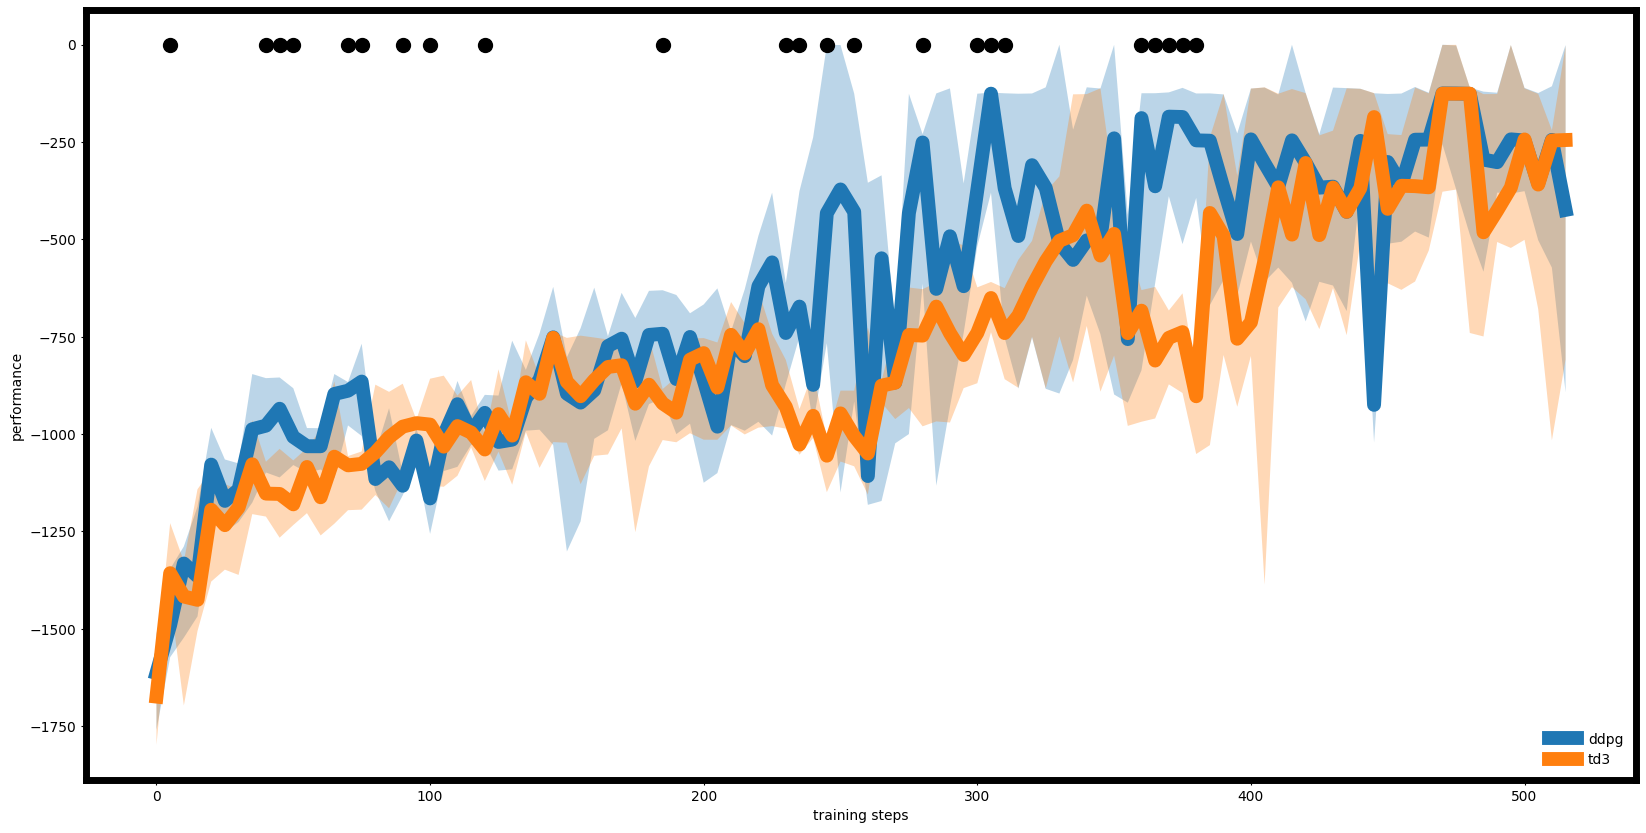

In [18]:
from bbrl.stats import WelchTTest

WelchTTest().plot(
    torch.stack(ddpg.eval_rewards),
    torch.stack(td3.eval_rewards),
    legends="ddpg/td3",
    save=False,
)